# Rice Datathon

### Importing Libraries and Reading Data

In [38]:
#importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns

In [39]:
#reading in data
df = pd.read_csv("training.csv")
df.head()

,StoreNumber,dayOfTheYear,3HourBucket,GrossSoldQuantity,Cash/Credit Site,EBT Site,Loyalty Site,ExtraMile Site,CoBrand,Alcohol,Carwash,Food Service,City,State
0,1000,1,1,3,False,True,True,True,No,True,False,True,HOUSTON,TX
1,1000,1,2,5,False,True,True,True,No,True,False,True,HOUSTON,TX
2,1000,1,3,6,False,True,True,True,No,True,False,True,HOUSTON,TX
3,1000,1,4,3,False,True,True,True,No,True,False,True,HOUSTON,TX
4,1000,2,1,13,False,True,True,True,No,True,False,True,HOUSTON,TX


### Data Exploration, Visualization and Cleaning

In [40]:
print("Dataset has {} entries and {} features".format(*df.shape))

Dataset has 5660 entries and 14 features


In [41]:
#discard variables that only have 1 unique value
for i in df.columns[df.columns != 'GrossSoldQuantity']:
    if len(df[i].unique()) < 2:
        df = df.drop(i, axis = 1)

#discard city as it's redundant. we're  using store number for our unique store identifier.
df = df.drop('City', axis = 1)

In [42]:
print("Dataset has {} entries and {} features".format(*df.shape))

Dataset has 5660 entries and 7 features


In [43]:
#we found through our tableau visualizations that there is a pattern between the day of the week and sales
#so we did a little feature engineering and created a variable for the day of the week
df['Day'] = [i%7 for i in df['dayOfTheYear']]

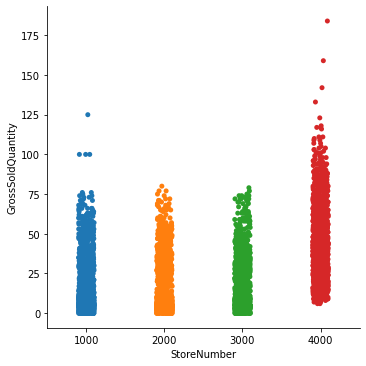

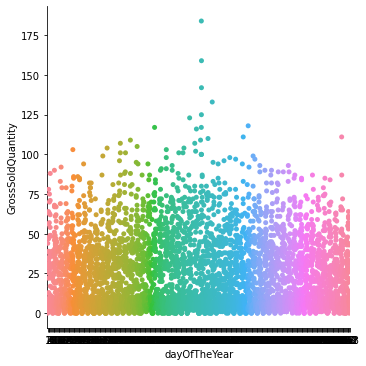

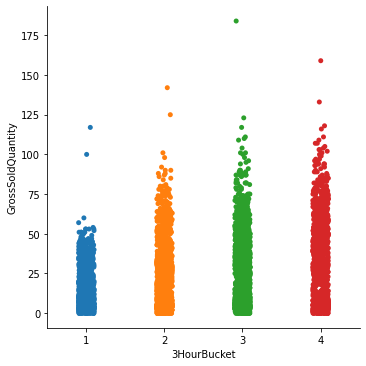

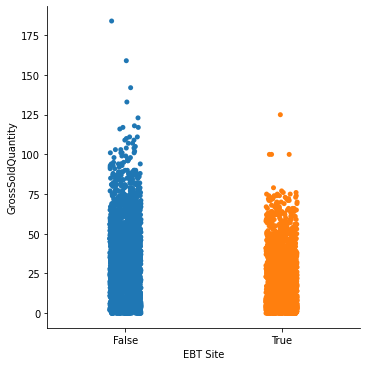

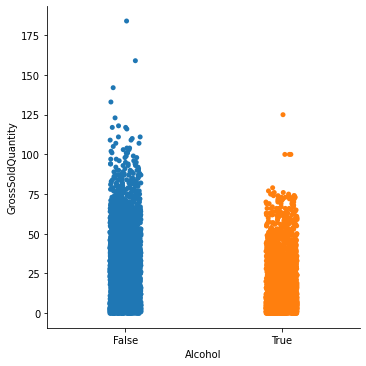

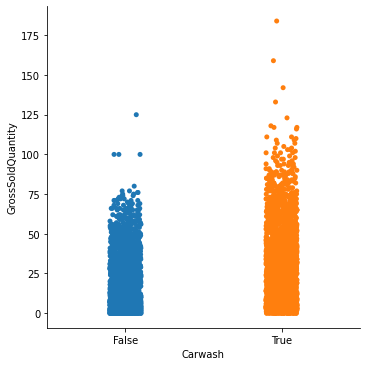

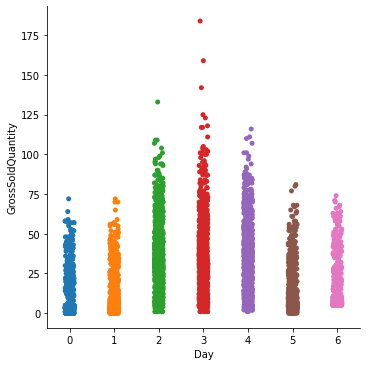

In [44]:
#plot all variables (excluding the target variable) against the target variable (sales)
for i in df.columns[df.columns != 'GrossSoldQuantity']:
    sns.catplot(x = i, y = 'GrossSoldQuantity', data = df)

In [45]:
#first quartile
q1 = df['GrossSoldQuantity'].quantile(.25)
q1

5.0

In [46]:
#third quartile
q3 = df['GrossSoldQuantity'].quantile(.75)
q3

36.0

In [47]:
#interquartile range
iqr = q3 - q1
iqr

31.0

In [48]:
#lower limit for outliers, lower than 0 so no need to account for
lower = q1 - 1.5 * iqr
lower

-41.5

In [49]:
#upper limit for outliers
upper = q3 + 1.5 * iqr
upper

82.5

In [50]:
#discard outlier values
df = df[df['GrossSoldQuantity'] <= upper]

In [51]:
print("Dataset has {} entries and {} features".format(*df.shape))

Dataset has 5564 entries and 8 features


### Preparing the Data for Modeling

In [52]:
#create training and test sets, encode
X = df[['StoreNumber', 'dayOfTheYear', '3HourBucket', 'EBT Site', 'Alcohol', 'Carwash', 'Day']]
y = df[['GrossSoldQuantity']]
X.head()

,StoreNumber,dayOfTheYear,3HourBucket,EBT Site,Alcohol,Carwash,Day
0,1000,1,1,True,True,False,1
1,1000,1,2,True,True,False,1
2,1000,1,3,True,True,False,1
3,1000,1,4,True,True,False,1
4,1000,2,1,True,True,False,2


In [53]:
#splitting training and testing sets, 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### Hyperparameter Tuning

In [54]:
#base parameters
#optimize both bias and variance
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
}

params['eval_metric'] = 'rmse'
num_boost_round = 999

XGBoost is used because it is robust to outliers, overfitting, missing values, multicollinearity, and does not require normalization, encoding, etc. It is an optimized gradient boosting algorithm that is one of the best for small-to-medium structured/tabular data.

In [55]:
#initial run
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:21.49083
[1]	Test-rmse:16.57791
[2]	Test-rmse:13.45169
[3]	Test-rmse:11.56023
[4]	Test-rmse:10.42264
[5]	Test-rmse:9.83562
[6]	Test-rmse:9.50823
[7]	Test-rmse:9.34636
[8]	Test-rmse:9.26483
[9]	Test-rmse:9.18116
[10]	Test-rmse:9.12248
[11]	Test-rmse:9.09427
[12]	Test-rmse:9.10369
[13]	Test-rmse:9.06214
[14]	Test-rmse:9.05702
[15]	Test-rmse:9.08793
[16]	Test-rmse:9.10484
[17]	Test-rmse:9.10043
[18]	Test-rmse:9.12671
[19]	Test-rmse:9.13621
[20]	Test-rmse:9.13002
[21]	Test-rmse:9.16238
[22]	Test-rmse:9.17856
[23]	Test-rmse:9.17997


In [56]:
#tabular data
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.429076,0.115736,21.448860,0.464698
1,16.410833,0.097734,16.482901,0.379002
2,13.203071,0.083535,13.329858,0.319725
3,11.237261,0.080927,11.453513,0.285367
4,10.089813,0.080843,10.396314,0.278248
5,9.418150,0.077789,9.813906,0.296150
6,9.038878,0.078629,9.506742,0.308977
7,8.795550,0.101443,9.352752,0.321232
8,8.614677,0.117799,9.281023,0.340294
9,8.505207,0.106871,9.232415,0.354461


In [57]:
#lowest value
cv_results['test-rmse-mean'].min()

9.189789000000001

In [58]:
#tune max_depth and min_child_weight
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1, 20)
    for min_child_weight in range(1, 20)
]

In [59]:
#iterate through combinations of parameter values and get lowest value
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=1, min_child_weight=1
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=2
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=3
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=4
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=5
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=6
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=7
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=8
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=9
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=10
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=11
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=12
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=13
	RMSE 11.1513018 for 72 rounds
CV with max_depth=1, min_child_weight=14
	RMSE 11.1513018 for 72 rounds
C

In [60]:
#set parameter values to most optimal values
params['max_depth'] = 7
params['min_child_weight'] = 13

In [61]:
#tune subsample and colsample
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(1, 11)]
    for colsample in [i/10. for i in range(1, 11)]
]

In [62]:
#iterate through combinations of parameter values and get lowest value
min_rmse = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	RMSE 9.0693716 for 13 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 9.097186400000002 for 13 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 9.143487400000001 for 16 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 9.2397784 for 24 rounds
CV with subsample=1.0, colsample=0.6
	RMSE 9.2397784 for 24 rounds
CV with subsample=1.0, colsample=0.5
	RMSE 9.5293188 for 41 rounds
CV with subsample=1.0, colsample=0.4
	RMSE 9.981304 for 78 rounds
CV with subsample=1.0, colsample=0.3
	RMSE 9.981304 for 78 rounds
CV with subsample=1.0, colsample=0.2
	RMSE 11.2714034 for 71 rounds
CV with subsample=1.0, colsample=0.1
	RMSE 11.2714034 for 71 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 9.1079578 for 10 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 9.1323768 for 14 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 9.2017506 for 14 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 9.2459562 for 27 rounds
CV with subsample=0.9, colsample=0.6
	RMSE 9.2

In [63]:
#set parameter values to optimal values
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

In [64]:
#iterate through combinations of parameter values and get lowest value
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    
    params['eta'] = eta
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['rmse'],
        early_stopping_rounds=10
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with eta=0.3
	RMSE 9.0693716 for 13 rounds

CV with eta=0.2
	RMSE 9.106549 for 19 rounds

CV with eta=0.1
	RMSE 9.0946456 for 43 rounds

CV with eta=0.05
	RMSE 9.090660199999999 for 91 rounds

CV with eta=0.01
	RMSE 9.089295600000002 for 455 rounds

CV with eta=0.005
	RMSE 9.092857200000001 for 891 rounds

Best params: 0.3, RMSE: 9.0693716


In [65]:
#set parameter value to optimal value
params['eta'] = .3

In [66]:
#our optimal parameter values
params

{'max_depth': 7,
 'min_child_weight': 13,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [67]:
#train model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-rmse:21.42850
[1]	Test-rmse:16.43974
[2]	Test-rmse:13.30599
[3]	Test-rmse:11.39801
[4]	Test-rmse:10.31852
[5]	Test-rmse:9.73058
[6]	Test-rmse:9.42009
[7]	Test-rmse:9.22017
[8]	Test-rmse:9.12137
[9]	Test-rmse:9.06813
[10]	Test-rmse:9.04954
[11]	Test-rmse:9.00334
[12]	Test-rmse:9.00993
[13]	Test-rmse:9.01219
[14]	Test-rmse:9.00060
[15]	Test-rmse:9.00022
[16]	Test-rmse:9.01722
[17]	Test-rmse:9.02779
[18]	Test-rmse:9.03321
[19]	Test-rmse:9.02731
[20]	Test-rmse:9.03637
[21]	Test-rmse:9.04610
[22]	Test-rmse:9.05370
[23]	Test-rmse:9.05352
[24]	Test-rmse:9.05652
[25]	Test-rmse:9.05853
Best RMSE: 9.00 in 16 rounds


In [68]:
#train model to optimal iteration
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:21.42850
[1]	Test-rmse:16.43974
[2]	Test-rmse:13.30599
[3]	Test-rmse:11.39801
[4]	Test-rmse:10.31852
[5]	Test-rmse:9.73058
[6]	Test-rmse:9.42009
[7]	Test-rmse:9.22017
[8]	Test-rmse:9.12137
[9]	Test-rmse:9.06813
[10]	Test-rmse:9.04954
[11]	Test-rmse:9.00334
[12]	Test-rmse:9.00993
[13]	Test-rmse:9.01219
[14]	Test-rmse:9.00060
[15]	Test-rmse:9.00022


In [69]:
#RMSE score
mean_squared_error(best_model.predict(dtest), y_test, squared = False)

9.000218600343867

In [70]:
#save model
best_model.save_model("best.model")

### Predicting

In [71]:
#load model and predict
loaded_model = xgb.Booster()
loaded_model.load_model("best.model")
predictions = [round(i) for i in loaded_model.predict(xgb.DMatrix(X_test))]
predictions

[2,
 32,
 3,
 32,
 40,
 36,
 3,
 27,
 2,
 7,
 11,
 37,
 37,
 15,
 15,
 60,
 36,
 31,
 34,
 8,
 38,
 12,
 4,
 34,
 43,
 3,
 39,
 37,
 2,
 4,
 35,
 7,
 7,
 40,
 6,
 8,
 3,
 17,
 3,
 40,
 4,
 57,
 35,
 29,
 9,
 3,
 18,
 6,
 45,
 4,
 56,
 55,
 8,
 6,
 8,
 40,
 8,
 35,
 36,
 7,
 3,
 6,
 6,
 58,
 41,
 28,
 2,
 35,
 33,
 18,
 14,
 40,
 6,
 7,
 5,
 11,
 52,
 33,
 35,
 24,
 4,
 2,
 4,
 35,
 7,
 38,
 6,
 44,
 32,
 39,
 7,
 7,
 36,
 36,
 38,
 6,
 38,
 2,
 46,
 60,
 35,
 6,
 7,
 9,
 6,
 40,
 8,
 35,
 5,
 35,
 44,
 4,
 32,
 7,
 32,
 36,
 2,
 1,
 6,
 2,
 33,
 7,
 67,
 36,
 20,
 2,
 6,
 21,
 43,
 34,
 3,
 34,
 19,
 5,
 36,
 4,
 6,
 6,
 7,
 2,
 7,
 40,
 38,
 7,
 47,
 3,
 39,
 6,
 8,
 37,
 56,
 16,
 4,
 2,
 4,
 12,
 15,
 7,
 7,
 34,
 4,
 45,
 22,
 22,
 38,
 42,
 18,
 29,
 59,
 34,
 8,
 4,
 3,
 25,
 8,
 36,
 3,
 12,
 35,
 31,
 5,
 38,
 6,
 18,
 4,
 17,
 11,
 63,
 35,
 3,
 33,
 8,
 32,
 6,
 7,
 8,
 61,
 39,
 29,
 4,
 5,
 33,
 31,
 3,
 19,
 3,
 34,
 4,
 33,
 34,
 8,
 16,
 38,
 46,
 64,
 17,
 2,
 7,
 35,
 

In [72]:
#RMSE score
mean_squared_error(predictions, y_test, squared = False)

9.010838450490516